In [2]:
# In this Jupyter Notebook, we introduce the adaptive pseudo-label selection algorithm, the distribution-based correction module, and the meta-learning-based correction module, respectively.

# the adaptive pseudo-label selection algorithm

In [7]:
#SEVR (Reﬁnement from classiﬁcation to regression)
def sevf(latent_softmax):
     list=[]
     for i in range(latent_softmax.shape[0]):
         ostime = 0
         for j in range(latent_softmax.shape[1]):
             ostime = ostime+j*10*result[i][j]
         list.append(ostime)
     return list

In [ ]:
def ce_loss(logits, targets, reduction='none'):
    
        log_pred = F.log_softmax(logits, dim=-1
        
        return F.nll_loss(torch.Tensor(sevf(log_pred)), targets*10, reduction=reduction)

In [3]:
# adaptive pseudo-label selection algorithm

def consistency_loss(logits_w, class_acc, p_cutoff):
    pseudo_label = torch.softmax(logits_w, dim=-1)
    max_probs, max_idx = torch.max(pseudo_label, dim=-1)
    mask = max_probs.ge(p_cutoff * (class_acc[max_idx] / (2. - class_acc[max_idx]))).float()
    select = max_probs.ge(p_cutoff).long()

    return (ce_loss(logits_w, max_idx.detach(), use_hard_labels=True,
                    reduction='none') * mask).mean(), select, max_idx.long()

In [ ]:
def classwise_statue(num_classes,num_un_dset,x_ulb_idx, logits_w, p_cutoff):
    #num_classes: the number of class
    #num_un_dset: the number of unlabeled dataset
    
    selected_label = torch.ones((num_un_dset,), dtype=torch.long, ) * -1
    classwise_acc = torch.zeros((num_classes))
    pseudo_counter = Counter(selected_label.tolist())
    if max(pseudo_counter.values()) < len(self.ulb_dset):  # not all(5w) -1
        for i in range(args.num_classes):
            classwise_acc[i] = pseudo_counter[i] / max(pseudo_counter.values())
            classwise_statue[i] = classwise_acc[i] / max(classwise_acc.values())
    unsup_loss, select, pseudo_lb = consistency_loss(logits_w, classwise_statue, p_cutoff)
    if x_ulb_idx[select == 1].nelement() != 0:
        selected_label[x_ulb_idx[select == 1]] = pseudo_lb[select == 1]
    
    return classwise_statue

In [ ]:
def adaptive_pseudo_label_selection(logits_w,classwise_statue, p_cutoff):
    
    apls_loss, select, pseudo_lb = consistency_loss(logits_w, classwise_statue, p_cutoff)

    return apls_loss

# the distribution-based correction module

In [4]:
#the distribution-based correction module
from scipy.special import rel_entr
def meta_learning_bcorrection(p,q):  

    return sum(rel_entr(P, Q))

# the meta-learning-based correction module

In [1]:
# meta model
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MetaNet(nn.Module):
    def __init__(self, hx_dim, cls_dim, h_dim, num_classes, args):
        super().__init__()

        self.args = args

        self.num_classes = num_classes        
        self.in_class = self.num_classes 
        self.hdim = h_dim
        self.cls_emb = nn.Embedding(self.in_class, cls_dim)

        in_dim = hx_dim + cls_dim

        self.net = nn.Sequential(
            nn.Linear(in_dim, self.hdim),
            nn.Tanh(),
            nn.Linear(self.hdim, self.hdim),
            nn.Tanh(),
            nn.Linear(self.hdim, num_classes + int(self.args.skip), bias=(not self.args.tie)) 
        )

        if self.args.sparsemax:
            from sparsemax import Sparsemax
            self.sparsemax = Sparsemax(-1)

        self.init_weights()

        if self.args.tie:
            print ('Tying cls emb to output cls weight')
            self.net[-1].weight = self.cls_emb.weight
        
    def init_weights(self):
        nn.init.xavier_uniform_(self.cls_emb.weight)
        nn.init.xavier_normal_(self.net[0].weight)
        nn.init.xavier_normal_(self.net[2].weight)
        nn.init.xavier_normal_(self.net[4].weight)

        self.net[0].bias.data.zero_()
        self.net[2].bias.data.zero_()

        if not self.args.tie:
            assert self.in_class == self.num_classes, 'In and out classes conflict!'
            self.net[4].bias.data.zero_()

    def get_alpha(self):
        return self.alpha if self.args.skip else torch.zeros(1)

    def forward(self, hx, y):
        bs = hx.size(0)

        y_emb = self.cls_emb(y)
        hin = torch.cat([hx, y_emb], dim=-1)

        logit = self.net(hin)

        if self.args.skip:
            alpha = torch.sigmoid(logit[:, self.num_classes:])
            self.alpha = alpha.mean()
            logit = logit[:, :self.num_classes]

        if self.args.sparsemax:
            out = self.sparsemax(logit) # test sparsemax
        else:
            out = F.softmax(logit, -1)

        if self.args.skip:
            out = (1.-alpha) * out + alpha * F.one_hot(y, self.num_classes).type_as(out)

        return out

In [ ]:

def step_hmlc_K(main_net, main_opt, hard_loss_f,
                meta_net, meta_opt, soft_loss_f,
                data_s, target_s, data_g, target_g,
                data_c, target_c, 
                eta, args):

    # compute gw for updating meta_net
    #data_g == data_gold
    logit_g = main_net(data_g)
    #hard_loss_f 主网络损失函数？
    loss_g = hard_loss_f(logit_g, target_g)
    #根据loss_g对主网络参数进行求导
    gw = torch.autograd.grad(loss_g, main_net.parameters())
    
    # given current meta net, get corrected label；data_silver == data_s 表示噪音标签
    logit_s, x_s_h = main_net(data_s, return_h=True)
    pseudo_target_s = meta_net(x_s_h.detach(), target_s)
    loss_s = soft_loss_f(logit_s, pseudo_target_s)

    if data_c is not None:
        bs1 = target_s.size(0)
        bs2 = target_c.size(0)

        logit_c = main_net(data_c)
        loss_s2 = hard_loss_f(logit_c, target_c)
        loss_s = (loss_s * bs1 + loss_s2 * bs2 ) / (bs1+bs2)

    f_param_grads = torch.autograd.grad(loss_s, main_net.parameters(), create_graph=True)    

    f_params_new, dparam_s = update_params(main_net.parameters(), f_param_grads, eta, main_opt, args, return_s=True)
    # 2. set w as w'
    f_param = []
    for i, param in enumerate(main_net.parameters()):
        f_param.append(param.data.clone())
        param.data = f_params_new[i].data # use data only as f_params_new has graph
    
    # training loss Hessian approximation
    Hw = 1 # assume to be identity 

    # 3. compute d_w' L_{D}(w')
    logit_g = main_net(data_g)
    loss_g  = hard_loss_f(logit_g, target_g)
    gw_prime = torch.autograd.grad(loss_g, main_net.parameters())

    # 3.5 compute discount factor gw_prime * (I-LH) * gw.t() / |gw|^2
    tmp1 = [(1-Hw*dparam_s[i]) * gw_prime[i] for i in range(len(dparam_s))]
    gw_norm2 = (_concat(gw).norm())**2
    tmp2 = [gw[i]/gw_norm2 for i in range(len(gw))]
    gamma = torch.dot(_concat(tmp1), _concat(tmp2))

    # because of dparam_s, need to scale up/down f_params_grads_prime for proxy_g/loss_g
    Lgw_prime = [ dparam_s[i] * gw_prime[i] for i in range(len(dparam_s))]     

    proxy_g = -torch.dot(_concat(f_param_grads), _concat(Lgw_prime))

    # back prop on alphas
    meta_opt.zero_grad()
    proxy_g.backward()
    
    # accumulate discounted iterative gradient
    for i, param in enumerate(meta_net.parameters()):
        if param.grad is not None:
            param.grad.add_(gamma * args.dw_prev[i])
            args.dw_prev[i] = param.grad.clone()

    if (args.steps+1) % (args.gradient_steps)==0: # T steps proceeded by main_net
        meta_opt.step()
        args.dw_prev = [0 for param in meta_net.parameters()] # 0 to reset 

    # modify to w, and then do actual update main_net
    for i, param in enumerate(main_net.parameters()):
        param.data = f_param[i]
        param.grad = f_param_grads[i].data
    main_opt.step()
    
    return loss_g, loss_s


In [5]:
# the meta-learning-based correction module

# example for the gradient normalization algorithm for optimization

In [2]:
# An example using the gradient normalization algorithm for optimization
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import pandas as pd
import math
import sklearn.preprocessing as sk
from tensorboardX import SummaryWriter
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import random

seed = 42
random.seed(seed)
torch.cuda.manual_seed_all(seed)

N = 10000
M = 100
c = 0.5
p = 0.9
k = np.random.randn(M)
u1 = np.random.randn(M)
u1 -= u1.dot(k) * k / np.linalg.norm(k)**2
u1 /= np.linalg.norm(u1) 
k /= np.linalg.norm(k) 
u2 = k
w1 = c*u1
w2 = c*(p*u1+np.sqrt((1-p**2))*u2)
X = np.random.normal(0, 1, (N, M))
eps1 = np.random.normal(0, 0.01)
eps2 = np.random.normal(0, 0.01)
Y1 = np.matmul(X, w1) + np.sin(np.matmul(X, w1))+eps1
Y2 = np.matmul(X, w2) + np.sin(np.matmul(X, w2))+eps2
split = list(np.random.permutation(N))

X_train = X[split[0:8000],:]
Y1_train = Y1[split[0:8000]]
Y2_train = Y2[split[0:8000]]
X_valid = X[8000:9000,:]
Y1_valid = Y1[8000:9000]
Y2_valid = Y2[8000:9000]
X_test = X[9000:10000,:]
Y1_test = Y1[9000:10000]
Y2_test = Y2[9000:10000]
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(Y1_train.shape)
print(Y2_train.shape)
print(Y1_valid.shape)
print(Y2_valid.shape)
print(Y1_test.shape)
print(Y2_test.shape)

X_train = torch.from_numpy(X_train)
X_train = X_train.float()
Y1_train = torch.tensor(Y1_train)
Y1_train = Y1_train.float()
Y2_train = torch.tensor(Y2_train)
Y2_train = Y2_train.float()

X_valid = torch.from_numpy(X_valid)
X_valid = X_valid.float()
Y1_valid = torch.tensor(Y1_valid)
Y1_valid = Y1_valid.float()
Y2_valid = torch.tensor(Y2_valid)
Y2_valid = Y2_valid.float()

X_test = torch.from_numpy(X_test)
X_test = X_test.float()
Y1_test = torch.tensor(Y1_test)
Y1_test = Y1_test.float()
Y2_test = torch.tensor(Y2_test)
Y2_test = Y2_test.float()

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(Y1_train.shape)
print(Y2_train.shape)
print(Y1_valid.shape)
print(Y2_valid.shape)
print(Y1_test.shape)
print(Y2_test.shape)

/Users/yuehailin/anaconda3/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/yuehailin/anaconda3/lib/python3.7/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <E768216F-B573-3E0F-9E88-BEA2F43AAD8C> /Users/yuehailin/anaconda3/lib/python3.7/site-packages/torchvision/image.so
  Expected in:     <7EC12623-0CF1-3739-8CBB-242EFC29E2B3> /Users/yuehailin/.local/lib/python3.7/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


(8000, 100)
(1000, 100)
(1000, 100)
(8000,)
(8000,)
(1000,)
(1000,)
(1000,)
(1000,)
torch.Size([8000, 100])
torch.Size([1000, 100])
torch.Size([1000, 100])
torch.Size([8000])
torch.Size([8000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])


In [3]:
input_size, feature_size = X.shape
shared_layer_size = 64
tower_h1 = 32
tower_h2 = 16
output_size = 1
LR = 0.001
epoch = 50
mb_size = 100
cost1tr = []
cost2tr = []
cost1D = []
cost2D = []
cost1ts = []
cost2ts = []
costtr = []
costD = []
costts = []

class MTLnet(nn.Module):
    def __init__(self):
        super(MTLnet, self).__init__()
        self.sharedlayer = nn.Sequential(
            nn.Linear(feature_size, shared_layer_size),
            nn.ReLU(),
            nn.Dropout()
        )
        self.tower1 = nn.Sequential(
            nn.Linear(shared_layer_size, tower_h1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h1, tower_h2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h2, output_size)
        )
        self.tower2 = nn.Sequential(
            nn.Linear(shared_layer_size, tower_h1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h1, tower_h2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h2, output_size)
        )        

    def forward(self, x):
        h_shared = self.sharedlayer(x)
        out1 = self.tower1(h_shared)
        out2 = self.tower2(h_shared)
        return out1, out2

def random_mini_batches(XE, R1E, R2E, mini_batch_size = 10, seed = 42): 
    # Creating the mini-batches
    np.random.seed(seed)            
    m = XE.shape[0]                  
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_XE = XE[permutation,:]
    shuffled_X1R = R1E[permutation]
    shuffled_X2R = R2E[permutation]
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, int(num_complete_minibatches)):
        mini_batch_XE = shuffled_XE[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch_X1R = shuffled_X1R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_X2R = shuffled_X2R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    Lower = int(num_complete_minibatches * mini_batch_size)
    Upper = int(m - (mini_batch_size * math.floor(m/mini_batch_size)))
    if m % mini_batch_size != 0:
        mini_batch_XE = shuffled_XE[Lower : Lower + Upper, :]
        mini_batch_X1R = shuffled_X1R[Lower : Lower + Upper]
        mini_batch_X2R = shuffled_X2R[Lower : Lower + Upper]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    
    return mini_batches

Weightloss1 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)
Weightloss2 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)

params = [Weightloss1, Weightloss2]
MTL = MTLnet()
opt1 = torch.optim.Adam(MTL.parameters(), lr=LR)
opt2 = torch.optim.Adam(params, lr=LR)
loss_func = nn.MSELoss()
Gradloss = nn.L1Loss()

/Users/yuehailin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/yuehailin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/Users/yuehailin/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Iter-0; MTL loss: 0.9776
Iter-1; MTL loss: 0.7024
Iter-2; MTL loss: 0.4869
Iter-3; MTL loss: 0.4029
Iter-4; MTL loss: 0.3392
Iter-5; MTL loss: 0.3286
Iter-6; MTL loss: 0.3004
Iter-7; MTL loss: 0.3124
Iter-8; MTL loss: 0.325
Iter-9; MTL loss: 0.3056
Iter-10; MTL loss: 0.3119
Iter-11; MTL loss: 0.2849
Iter-12; MTL loss: 0.261
Iter-13; MTL loss: 0.269
Iter-14; MTL loss: 0.2911
Iter-15; MTL loss: 0.2807
Iter-16; MTL loss: 0.2265
Iter-17; MTL loss: 0.2452
Iter-18; MTL loss: 0.2467
Iter-19; MTL loss: 0.2684
Iter-20; MTL loss: 0.2854
Iter-21; MTL loss: 0.2151
Iter-22; MTL loss: 0.2177
Iter-23; MTL loss: 0.2253
Iter-24; MTL loss: 0.212
Iter-25; MTL loss: 0.2505
Iter-26; MTL loss: 0.227
Iter-27; MTL loss: 0.2269
Iter-28; MTL loss: 0.2415
Iter-29; MTL loss: 0.2394
Iter-30; MTL loss: 0.2225
Iter-31; MTL loss: 0.2414
Iter-32; MTL loss: 0.2335
Iter-33; MTL loss: 0.2303
Iter-34; MTL loss: 0.2663
Iter-35; MTL loss: 0.2581
Iter-36; MTL loss: 0.2582
Iter-37; MTL loss: 0.2378
Iter-38; MTL loss: 0.2297
I

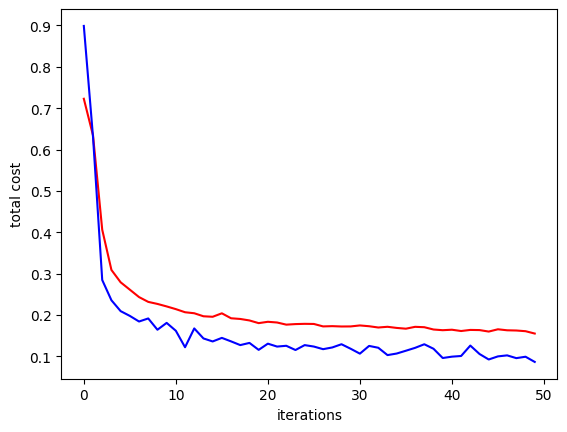

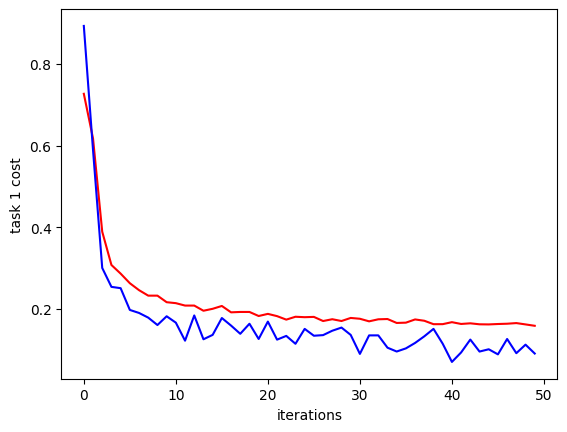

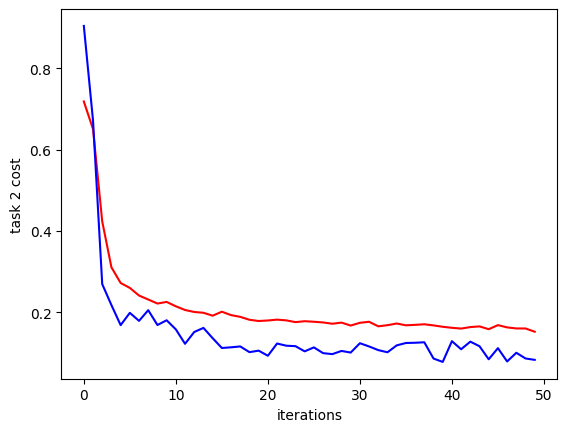

In [4]:
alph = 0.16
for it in range(epoch):
    epoch_cost = 0
    epoch_cost1 = 0
    epoch_cost2 = 0
    coef = 0
    num_minibatches = int(input_size / mb_size) 
    minibatches = random_mini_batches(X_train, Y1_train, Y2_train, mb_size)
    for minibatch in minibatches:
        MTL.train()
        XE, YE1, YE2  = minibatch 
        
        Yhat1, Yhat2 = MTL(XE)
        l1 = params[0]*loss_func(Yhat1, YE1.view(-1,1))    
        l2 = params[1]*loss_func(Yhat2, YE2.view(-1,1))
        loss = torch.div(torch.add(l1,l2), 2)

        # for the first epoch with no l0
        if it == 0:
            l01 = l1.data  
            l02 = l2.data
        
        opt1.zero_grad()
        
        loss.backward(retain_graph=True)   
        
        # Getting gradients of the first layers of each tower and calculate their l2-norm 
        param = list(MTL.parameters())
        G1R = torch.autograd.grad(l1, param[0], retain_graph=True, create_graph=True)
        G1 = torch.norm(G1R[0], 2)
        G2R = torch.autograd.grad(l2, param[0], retain_graph=True, create_graph=True)
        G2 = torch.norm(G2R[0], 2)
        G_avg = torch.div(torch.add(G1, G2), 2)
        
        # Calculating relative losses 
        lhat1 = torch.div(l1,l01)
        lhat2 = torch.div(l2,l02)
        lhat_avg = torch.div(torch.add(lhat1, lhat2), 2)
        
        # Calculating relative inverse training rates for tasks 
        inv_rate1 = torch.div(lhat1,lhat_avg)
        inv_rate2 = torch.div(lhat2,lhat_avg)
        
        # Calculating the constant target for Eq. 2 in the GradNorm paper
        C1 = G_avg*(inv_rate1)**alph
        C2 = G_avg*(inv_rate2)**alph
        C1 = C1.detach()
        C2 = C2.detach()
        
        opt2.zero_grad()
        # Calculating the gradient loss according to Eq. 2 in the GradNorm paper
        Lgrad = torch.add(Gradloss(G1, C1),Gradloss(G2, C2))
        Lgrad.backward()
        
        # Updating loss weights 
        opt2.step()

        # Updating the model weights
        opt1.step()

        # Renormalizing the losses weights
        coef = 2/torch.add(Weightloss1, Weightloss2)
        params = [coef*Weightloss1, coef*Weightloss2]
        #print("Weights are:",Weightloss1, Weightloss2)
        #print("params are:", params)
        epoch_cost = epoch_cost + (loss / num_minibatches)
        epoch_cost1 = epoch_cost1 + (l1 / num_minibatches)
        epoch_cost2 = epoch_cost2 + (l2 / num_minibatches)
        
    costtr.append(torch.mean(epoch_cost))
    cost1tr.append(torch.mean(epoch_cost1))
    cost2tr.append(torch.mean(epoch_cost2))
    
    with torch.no_grad():
        MTL.eval()
        Yhat1D, Yhat2D = MTL(X_valid)
        l1D = params[0]*loss_func(Yhat1D, Y1_valid.view(-1,1))
        l2D = params[1]*loss_func(Yhat2D, Y2_valid.view(-1,1))
        cost1D.append(l1D)
        cost2D.append(l2D)
        costD.append(torch.div(torch.add(l1D,l2D),2))
        print('Iter-{}; MTL loss: {:.4}'.format(it, loss.item()))
        #print('Iter-{}; Grad loss: {:.4}'.format(it, Lgrad.item()))
    
plt.plot(np.squeeze(costtr),'-r',np.squeeze(costD), '-b')
plt.ylabel('total cost')
plt.xlabel('iterations')
plt.show() 

plt.plot(np.squeeze(cost1tr),'-r', np.squeeze(cost1D), '-b')
plt.ylabel('task 1 cost')
plt.xlabel('iterations')
plt.show() 

plt.plot(np.squeeze(cost2tr),'-r', np.squeeze(cost2D),'-b')
plt.ylabel('task 2 cost')
plt.xlabel('iterations')
plt.show()